Problem 3
=======

/Users/jeongminlee/miniforge3/envs/py311/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.Logistic'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


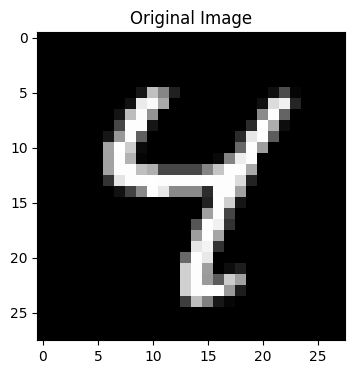

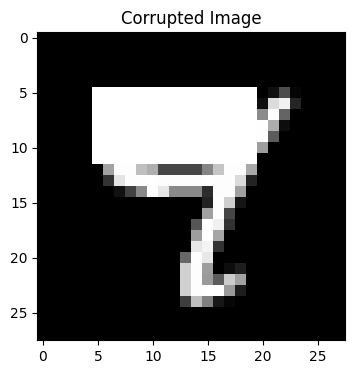

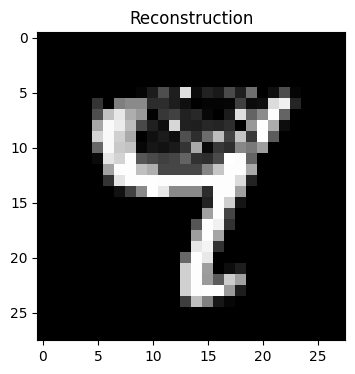

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device("cpu")

############################################
# STEP 1: Define dataset and preprocessing #
############################################


class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)
    
####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config
        
        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                                                 for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J
    
##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)


# Load pre-trained NICE model onto CPU
model = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
model.load_state_dict(torch.load('nice.pt',map_location=torch.device('cpu')))

# Since we do not update model, set requires_grad = False
model.requires_grad_(False)

# Get an MNIST image
testset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
pass_count = 6
itr = iter(test_loader)
for _ in range(pass_count+1):
    image,_ = next(itr)
    
plt.figure(figsize = (4,4))
plt.title('Original Image')
plt.imshow(make_grid(image.squeeze().detach()).permute(1,2,0))
# plt.show()
plt.savefig('plt1.png')


# Create mask 
mask = torch.ones_like(image,dtype=torch.bool)
mask[:,:,5:12,5:20] = 0

# Partially corrupt the image
image[mask.logical_not()] = torch.ones_like(image[mask.logical_not()])
plt.figure(figsize = (4,4))
plt.title('Corrupted Image')
plt.imshow(make_grid(image.squeeze()).permute(1,2,0))
# plt.show()
plt.savefig('plt2.png')


lr = 1e-3

X = image.clone().requires_grad_(True)

# Set optimizer
optimizer = torch.optim.SGD([X], lr=lr)

# Define the inpainting loop that projects the gradients and performs the update
for i in range(300):
    optimizer.zero_grad()
    loss = -model(X.view(1, -1))
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        X.data = torch.clamp(X.data, min = 0, max = 1)
        X.data[mask] = image.data[mask]

recon = X.detach().view(1, 28, 28)
# Plot reconstruction
plt.figure(figsize = (4,4))
plt.title('Reconstruction')
plt.imshow(make_grid(recon.squeeze().detach()).permute(1,2,0))
# plt.show()
plt.savefig('plt3.png')


Problem 5
=========

In [73]:
import numpy as np

# Set the parameters
p = 18 / 37  # Probability of winning
q = 0.55     # Importance sampling probability (q > p)
initial_balance = 100
goal = 200
num_simulations = 3000
max_games = 600

def run_simulation(p, q, initial_balance, goal, max_games):
    balance = initial_balance
    weight = 1.0  # Initialize the weight for importance sampling
    
    for _ in range(max_games):
        # Simulate a game with the importance sampling distribution
        if np.random.rand() < q:
            balance += 1  # Win
            weight *= p / q  # Update the weight
        else:
            balance -= 1  # Lose
            weight *= (1 - p) / (1 - q)  # Update the weight
        if balance == 0 or balance == goal:
            break
        return balance == goal, weight

results = [run_simulation(p, q, initial_balance, goal, max_games) for _ in range(num_simulations)]

probability_estimate = sum(weight for success, weight in results if success) / num_simulations
print(f'Estimated probability of reaching ${goal} before going broke: {probability_estimate}')


Estimated probability of reaching $200 before going broke: 2.756788395553154e-06


Problem 6
==========

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

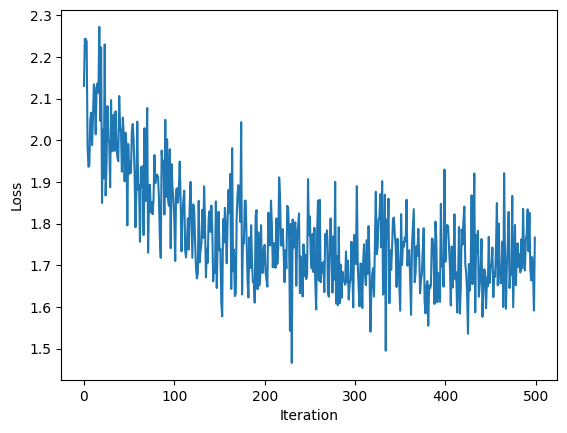

0.43991562724113464
0.6408485928969797


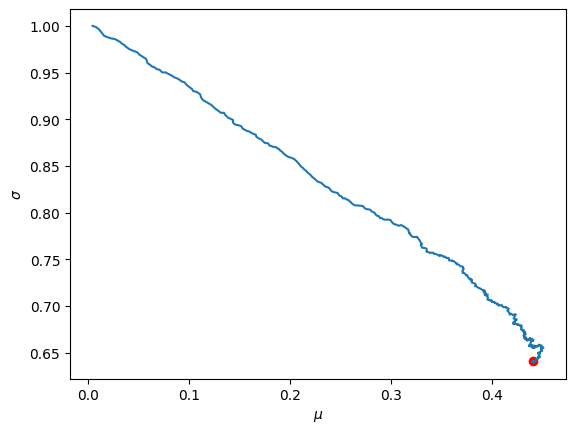

In [24]:
mu = 0
tau = 0
B = 32
lr = 1e-1
iteration = 500

logger = []
history = []

def loss(X, mu, tau):
    return torch.sum(X*torch.sin(X))/X.shape[0] + 0.5*(mu-1)**2 + np.exp(tau) - tau

for _ in range(iteration):
    sigma = np.exp(tau)
    X = np.exp(tau)*torch.normal(0,1,size=(B,1)) + mu
    g1 = torch.sum(X*torch.sin(X)*((X-mu)/np.exp(2*tau)))/B + mu -1
    g2 = torch.sum(X*torch.sin(X)*(-1 + (X-mu)**2*np.exp(-2*tau)))/B + np.exp(tau)-1
    mu -= lr*g1/B
    tau -=lr*g2/B
    logger.append(loss(X, mu, tau))
    history.append([mu.item(),sigma])

plt.plot(range(iteration),logger)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

history = np.array(history)
plt.plot(history[:,0],history[:,1])
plt.scatter(history[-1,0],history[-1,1],color = 'r')
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")


print(mu.item())
print(np.exp(tau.item()))

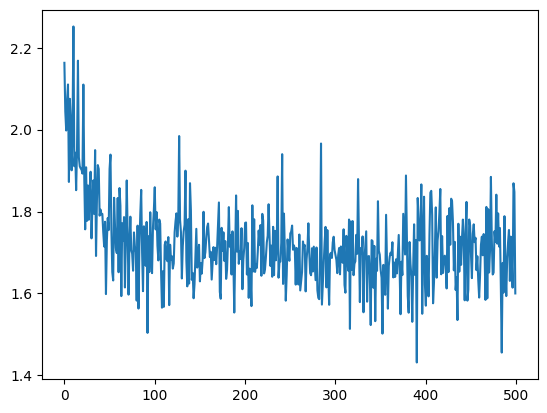

0.45562297105789185
0.6033352402082047


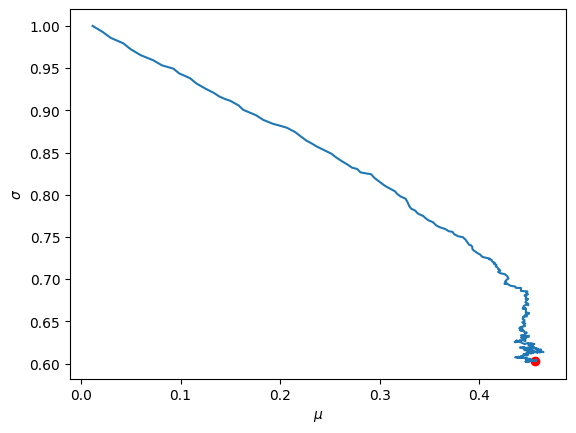

In [25]:
mu = 0
tau = 0
B = 32
lr = 1e-2
iteration = 500

logger = []
history = []

def loss(X, mu, tau):
    return torch.sum(X*torch.sin(X))/X.shape[0] + 0.5*(mu-1)**2 + np.exp(tau) - tau

for _ in range(iteration):
    Y = torch.normal(0,1,size=(B,1))
    sigma = np.exp(tau)
    X = mu + sigma*Y
    g1 = torch.sum(torch.sin(X) + X*torch.cos(X))/B + mu-1
    g2 = torch.sum((torch.sin(X) + X*torch.cos(X))*sigma*Y)/B + sigma - 1

    mu -= lr*g1
    tau -=lr*g2

    logger.append(loss(X, mu, tau))
    history.append([mu.item(),sigma])

plt.plot(range(iteration),logger)
plt.show()

history = np.array(history)
plt.plot(history[:,0],history[:,1])
plt.scatter(history[-1,0],history[-1,1],color = 'r')
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")

print(mu.item())
print(np.exp(tau.item()))